In [4]:
using Gen, Distributions
using StatsPlots
using StatsBase
using DataFrames

┌ Info: Precompiling Gen [ea4f424c-a589-11e8-07c0-fd5c91b9da4a]
└ @ Base loading.jl:1423


## Agent Simulation

In [5]:
food = [1,2,3]

3-element Vector{Int64}:
 1
 2
 3

In [6]:
distance = [10, 3, 15]

3-element Vector{Int64}:
 10
  3
 15

In [7]:
waiting_time = [2.,5.5,1.]

3-element Vector{Float64}:
 2.0
 5.5
 1.0

In [8]:
preference = [0.7, 1.1, 1.3]

3-element Vector{Float64}:
 0.7
 1.1
 1.3

In [9]:
restaurant_visits = zeros(3)

3-element Vector{Float64}:
 0.0
 0.0
 0.0

In [10]:
@gen function easy_agent_datasource()
    favourite_food ~ categorical([1/3, 1/3, 1/3])
    distance ~ categorical([1/3, 1/3, 1/3])
    waittime ~ categorical([1/3, 1/3, 1/3])
    return mode((favourite_food, distance, waittime))
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[], false, Union{Nothing, Some{Any}}[], var"##easy_agent_datasource#274", Bool[], false)

In [11]:
easy_agent_datasource(),easy_agent_datasource(),easy_agent_datasource()

(2, 3, 2)

In [12]:
waittimes = DataFrame(Restaurant=[:A,:B, :A,:A,:C,:C], Waittime=[2., 5.5,2.2, 2.1, 1., 1.])

,Restaurant,Waittime
,Symbol,Float64
1,A,2.0
2,B,5.5
3,A,2.2
4,A,2.1
5,C,1.0
6,C,1.0


In [13]:
@gen function waittime_model(visits)
    w_bar ~ gamma(2, 1)
    w_i = Dict()
    w_i[:A] = {(:w_i, :A)} ~ gamma(w_bar, 1)
    w_i[:B] = {(:w_i, :B)} ~ gamma(w_bar, 1)
    w_i[:C] = {(:w_i, :C)} ~ gamma(w_bar, 1)
    
    
    waittimes = Vector{Float64}(undef,length(visits))
    for (i,v) in enumerate(visits)
       waittimes[i] = {(:waittime,i)} ~ gamma(w_i[v], 1)
    end
    return waittimes
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##waittime_model#275", Bool[0], false)

In [14]:
waittime_model(waittimes.Restaurant)

6-element Vector{Float64}:
 3.1864403432466
 2.4508309950812968
 6.577754112467076
 8.74403339089292
 1.8302286785613604
 2.5939357940209558

In [15]:
observations = Gen.choicemap()

for (i,w) in enumerate(waittimes.Waittime)
    observations[(:waittime,i)] = w
end

traces = [importance_resampling(waittime_model, (waittimes.Restaurant,), observations, 100)[1] for _ in 1:100]

100-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##waittime_model#275", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}((:w_i, :A) => Gen.ChoiceOrCallRecord{Float64}(3.065739762694462, -1.5538542980838665, NaN, true), (:w_i, :B) => Gen.ChoiceOrCallRecord{Float64}(4.107872530538622, -2.0562099682151604, NaN, true), (:w_i, :C) => Gen.ChoiceOrCallRecord{Float64}(1.5462431866886754, -1.2969535113566146, NaN, true), (:waittime, 3) => Gen.ChoiceOrCallRecord{Float64}(2.2, -1.3259092734698648, NaN, true), (:waittime, 4) => Gen.ChoiceOrCallRecord{Float64}(2.1, -1.322007519528031, NaN, true), (:waittime, 6) => Gen.ChoiceOrCallRecord{Float64}(1.0, -0.8818912835063355, NaN, true), :w_bar => Gen.ChoiceOrCallRecord{Float64}(2.844657937264407, -1.7992151098621574, NaN, true), (:wa

In [16]:
function get_waittimes(traces)
    choices = Gen.get_choices.(traces)
    w_bars = Gen.get_value.(choices, :w_bar)
    w_is = Dict()
    w_is[:A] = Vector{Float64}(undef, length(choices))
    w_is[:B] = Vector{Float64}(undef, length(choices))
    w_is[:C] = Vector{Float64}(undef, length(choices))
    for (i,choice) in enumerate(choices)
        w_is[:A][i] = Gen.get_value(choice, (:w_i,:A))
        w_is[:B][i] = Gen.get_value(choice, (:w_i,:B))
        w_is[:C][i] = Gen.get_value(choice, (:w_i,:C))
    end
    w_bars_m, w_bars_std = mean_and_std(w_bars)
    w_A_is_m, w_A_is_std = mean_and_std(w_is[:A])
    w_B_is_m, w_B_is_std = mean_and_std(w_is[:B])
    w_C_is_m, w_C_is_std = mean_and_std(w_is[:C])

    return (w_bars_m,w_bars_std),(w_A_is_m, w_A_is_std),(w_B_is_m, w_B_is_std),(w_C_is_m, w_C_is_std)
end

get_waittimes (generic function with 1 method)

In [17]:
(w_bars_m,w_bars_std),(w_A_is_m, w_A_is_std),(w_B_is_m, w_B_is_std),(w_C_is_m, w_C_is_std) = get_waittimes(traces)

((2.690351517845024, 1.018560404494462), (2.480013363444321, 0.8215023768775955), (4.156213286088667, 1.8813757731338379), (1.723664002760114, 0.7184740232462831))

In [110]:
w_bars_m = []
w_bars_s = []

w_A_is_m = []
w_A_is_s = []

w_B_is_m = []
w_B_is_s = []


w_C_is_m = []
w_C_is_s = []


for i in 1:size(waittimes,1)  

    observations = Gen.choicemap()

    for (j,w) in enumerate(waittimes[1:i,:].Waittime)
        observations[(:waittime,j)] = w
    end

    traces = [importance_resampling(waittime_model, (waittimes[1:i,:].Restaurant,), observations, 100)[1] for _ in 1:100]
    (w_bar_m,w_bar_s),(w_A_i_m, w_A_i_s),(w_B_i_m, w_B_i_s),(w_C_i_m, w_C_i_s) = get_waittimes(traces)
    
    push!(w_bars_m, w_bar_m)
    push!(w_bars_s, w_bar_s)
    
    push!(w_A_is_m, w_A_i_m)
    push!(w_A_is_s, w_A_i_s)
    
    push!(w_B_is_m, w_B_i_m)
    push!(w_B_is_s, w_B_i_s)
    
    push!(w_C_is_m, w_C_i_m)
    push!(w_C_is_s, w_C_i_s)
    
end

w_bars_k = w_bars_m .^ 2 ./ w_bars_s .^ 2
w_bars_t = w_bars_s .^ 2 ./ w_bars_m

w_A_is_k = w_A_is_m .^ 2 ./ w_A_is_s .^ 2
w_A_is_t = w_A_is_s .^2 ./ w_A_is_m

w_B_is_k = w_B_is_m .^ 2 ./ w_B_is_s .^ 2
w_B_is_t = w_B_is_s .^2 ./ w_B_is_m

w_C_is_k = w_C_is_m .^ 2 ./ w_C_is_s .^ 2
w_C_is_t = w_C_is_s .^2 ./ w_C_is_m;

In [153]:
plts = Array{Any}(undef,(6,4))
for i in 1:size(waittimes, 1)
    plts[i,1] = plot(Gamma(w_bars_k[i], w_bars_t[i]), title="Wbar $i")
    plts[i,2] = plot(Gamma(w_A_is_k[i], w_A_is_t[i]), title="W A $i")
    plts[i,3] = plot(Gamma(w_B_is_k[i], w_B_is_t[i]), title="W B $i")
    plts[i,4] = plot(Gamma(w_C_is_k[i], w_C_is_t[i]), title="W C $i")
end



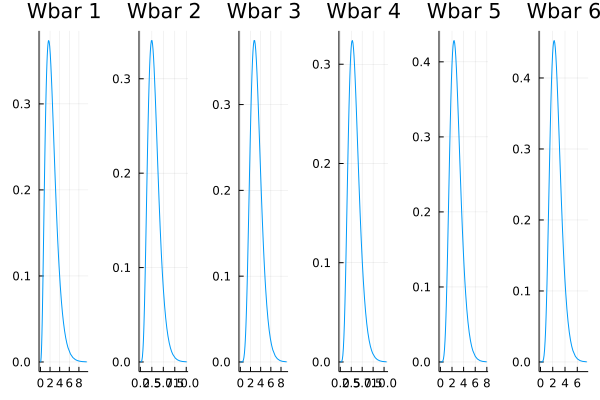

In [154]:
plot(plts[1:6,]..., layout=(1, 6), legend=false)

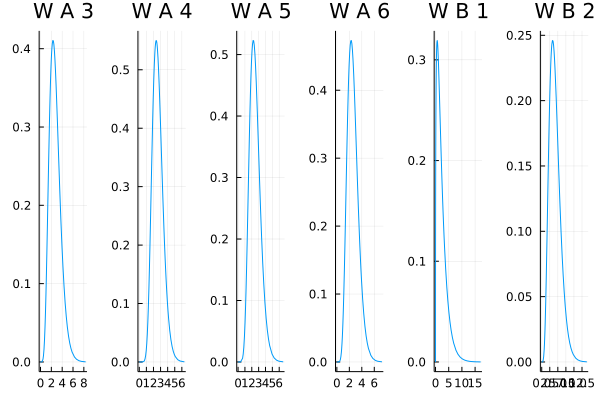

In [155]:
plot(plts[9:14,]..., layout=(1, 6), legend=false)

In [134]:
waiting_time = (w_A_is_m, w_B_is_m, w_C_is_m)

(Any[2.362786079856168, 2.550571985171601, 2.707690109864492, 2.605896807351152, 2.482964512624269, 2.587559827991335], Any[2.303466346638539, 4.137480649552414, 4.098157909755734, 4.453525577471928, 4.0177007823501825, 4.037708158388033], Any[2.503234676046892, 3.1284175981810978, 3.390097421530269, 3.244437005911925, 1.7090584805851157, 1.7827284822687435])

In [20]:
@gen function complex_agent_datasource(waittime)
    feeling_random ~ bernoulli(0.5)
    if feeling_random
        choice ~ categorical([1/3, 1/3, 1/3])
        return choice
    end
    gusto ~ categorical([1/3, 1/3, 1/3])
    temperature ~ normal(0,5)
    distance_bias = distance .* temperature
    hurry ~ bernoulli(0.9)
    time_bias = waittime .* hurry
    
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##complex_agent_datasource#276", Bool[0], false)

In [21]:
@gen function alternative_agent_datasource(waittime)
    un_probs = exp.((.- waittime ./ sum(waittime)) .+ (.- distance ./ sum(distance)) .+ preference ./ sum(preference))
    probs = un_probs ./ sum(un_probs)
    choice ~ categorical(probs)
    return choice
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##alternative_agent_datasource#277", Bool[0], false)

In [22]:
alternative_agent_datasource(waiting_time),alternative_agent_datasource(waiting_time),alternative_agent_datasource(waiting_time)

LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 3 and 6")

In [23]:
data_vector = [alternative_agent_datasource(waiting_time) for _ in 1:140]

LoadError: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 3 and 6")

In [24]:
data = DataFrame(RestaurantChoice=data_vector)

LoadError: UndefVarError: data_vector not defined

In [25]:
include("../inverse-planning/geometric_primitives.jl");
include("../inverse-planning/scene.jl");
include("../inverse-planning/planning.jl");
include("../inverse-planning/viz.jl");

In [26]:
scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)
add_obstacle!(scene, make_square(Point(0.30, 0.20), 0.1))
add_obstacle!(scene, make_square(Point(0.83, 0.80), 0.1))
add_obstacle!(scene, make_square(Point(0.80, 0.40), 0.1))
#add_obstacle!(scene, make_square(Point(0.50, 0.09), 0.05))
#add_obstacle!(scene, make_square(Point(0.10, 0.50), 0.05))
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.60, 0.40), 0.40, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.60 - 0.15, 0.80), 0.15 + wall_thickness, wall_thickness))
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.80), 0.15, wall_thickness))
add_obstacle!(scene, make_line(vertical, Point(0.20, 0.40), 0.40, wall_thickness));
add_obstacle!(scene, make_line(vertical, Point(0.50,0.0), 0.30, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.00,0.5), 0.20, wall_thickness));

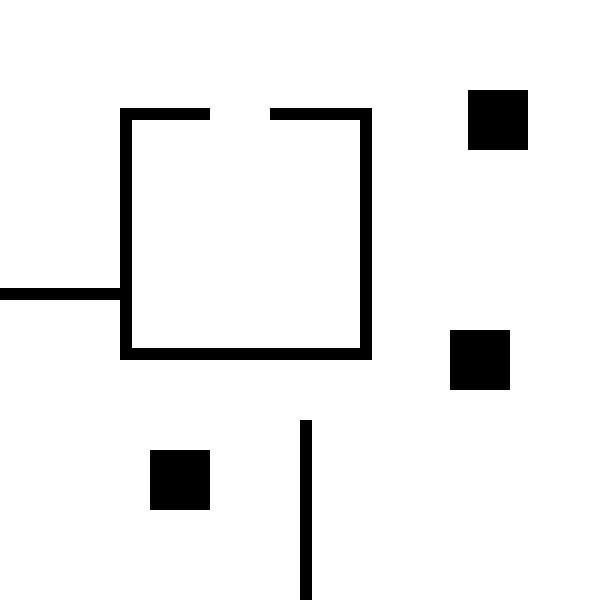

In [27]:
# We visualize the scene below.
visualize() do
    draw_scene(scene)
end

In [28]:
start = Point(0.1, 0.1)
dest = Point(0.5, 0.5)
planner_params = PlannerParams(rrt_iters=600, rrt_dt=3.0,
                               refine_iters=3500, refine_std=1.)
example_path1 = plan_path(start, dest, scene, planner_params)
example_path2 = plan_path(start, dest, scene, planner_params)
example_path3 = plan_path(start, dest, scene, planner_params)

Path(Point[Point(0.1, 0.1), Point(0.08619300252691049, 0.07350291651853275), Point(0.3520747703216933, 0.1496926435776621), Point(0.37736256328508744, 0.264752878088236), Point(0.42431265519271155, 0.2808813392722841), Point(0.5904014685177901, 0.32429635212055796), Point(0.7656285232657638, 0.5559976482278184), Point(0.7580131954388832, 0.5686306255664426), Point(0.5811381660190504, 0.9815916013296974), Point(0.5672908241661638, 0.9774367064168873), Point(0.5668843530475427, 0.931932048461393), Point(0.5364962003599032, 0.9019291105671196), Point(0.5079205674498601, 0.9191159798105832), Point(0.4727689067430061, 0.9888225687146952), Point(0.40766278204366246, 0.9968604363206925), Point(0.5, 0.5)])

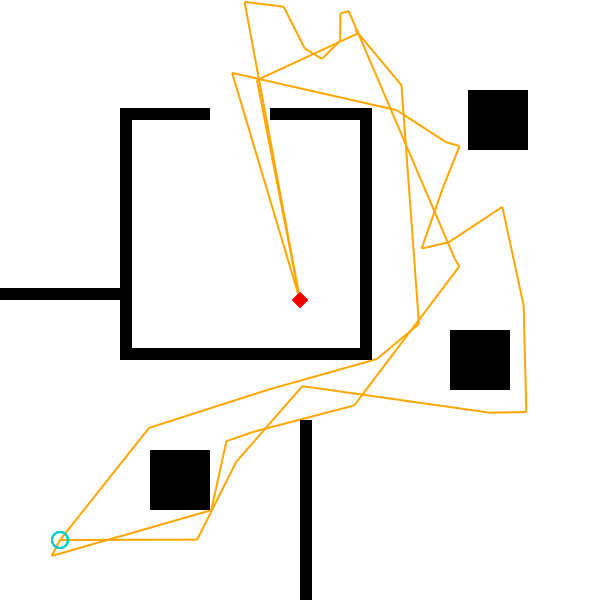

In [29]:
visualize() do
    draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path1.points);
               should_draw_measurements=false)
        draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path2.points);
               should_draw_measurements=false)
        draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path3.points);
               should_draw_measurements=false)
end

In [30]:
speed = 1.
dt = 0.1
num_ticks = 10;
example_locations = walk_path(example_path1, speed, dt, num_ticks)
println(example_locations)

Point[Point(0.1, 0.1), Point(0.19999968677965502, 0.10025028777616456), Point(0.29999937355931, 0.10050057555232911), Point(0.3605921001403438, 0.16440882617191896), Point(0.4109587378090896, 0.2500743742007887), Point(0.47678943873298596, 0.3253493289724026), Point(0.5621307688789547, 0.3481273632193053), Point(0.661144496899803, 0.33411730742307544), Point(0.7601582249206513, 0.32010725162684556), Point(0.8595932491473135, 0.31301780663204304)]


In [31]:
@gen function walk_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    dest_x ~ uniform(0, 1)
    dest_y ~ uniform(0, 1)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.02
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

In [32]:
@gen function chase_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    restaurant ~ categorical([1/2, 1/2])
    dest_x ~ normal(max(0.1, min(0.9, restaurant - 1)), 0.05)
    dest_y ~ normal(max(0.1, min(0.9, 2 - restaurant)), 0.05)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.02
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

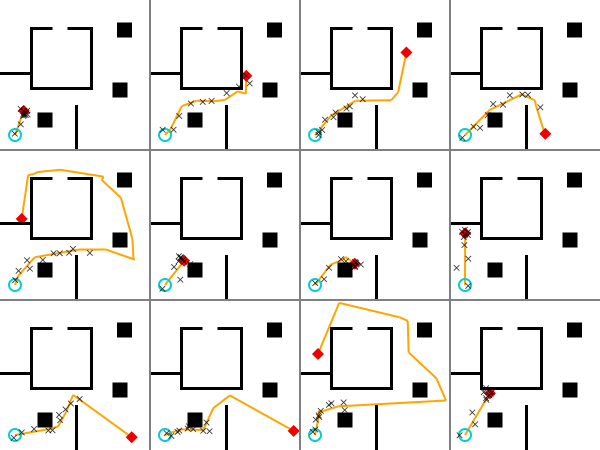

In [33]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1

traces = [Gen.generate(
    walk_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

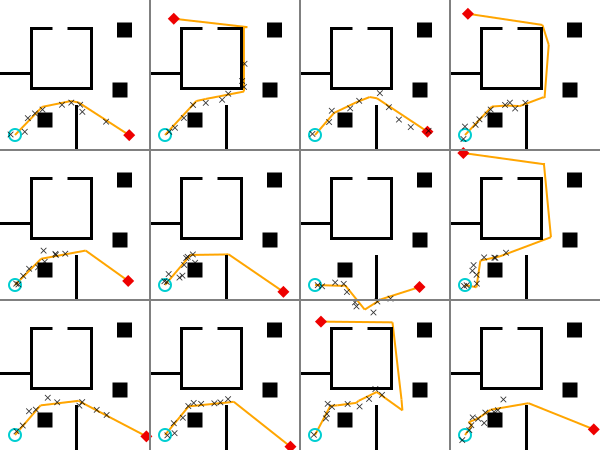

In [34]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.1
constraints[:start_y] = 0.1

traces = [Gen.generate(
    chase_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

In [35]:
measurements = [
    Point(0.0980245, 0.104775),
    Point(0.113734, 0.150773),
    Point(0.100412, 0.195499),
    Point(0.114794, 0.237386),
    Point(0.0957668, 0.277711),
    Point(0.140181, 0.31304),
    Point(0.124384, 0.356242),
    Point(0.122272, 0.414463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

In [36]:
function do_inference(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams, 
        start::Point, measurements::Vector{Point}, amount_of_computation::Int, model=walk_model)
    
    # Constrain the observed measurements.
    observations = Gen.choicemap()
    observations[:start_x] = start.x
    observations[:start_y] = start.y
    for (i, m) in enumerate(measurements)
        observations[:meas => (i, :x)] = m.x
        observations[:meas => (i, :y)] = m.y
    end
    
    trace, = importance_resampling(model, (scene, dt, num_ticks, planner_params), observations, amount_of_computation)
    
    return trace
end;

In [37]:
function visualize_inference(measurements, scene, start; computation_amt=50, samples=1000, num_ticks=num_ticks, draw_measurements=true, draw_path=false, statistics=false, restaurant_visits=zeros(3), model=walk_model)
    if statistics
        restaurant_visits .= 0
    end
    visualize() do
        for i in 1:samples
            trace = do_inference(scene, dt, num_ticks, planner_params, start, measurements, computation_amt, model)
            draw_trace(trace; draw_measurements=draw_measurements, draw_path=draw_path)
            if statistics && Gen.has_value(Gen.get_choices(trace), :restaurant)
                restaurant_visits[trace[:restaurant]] += 1
            end
        end
    end
end;

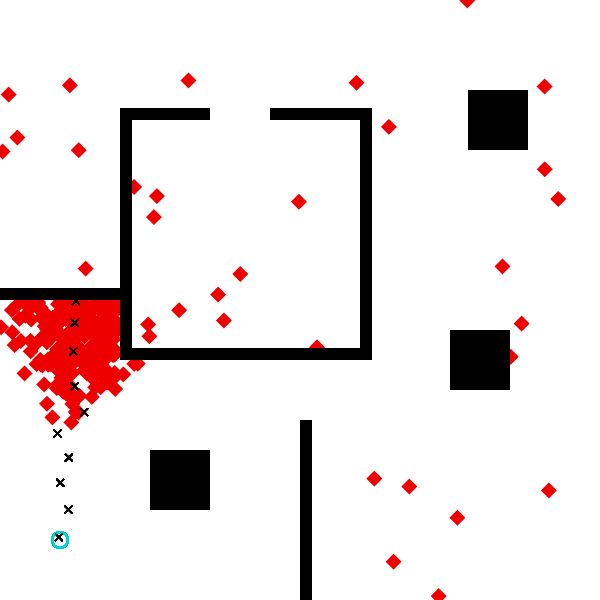

In [38]:
visualize_inference(
    measurements, scene, start, computation_amt=100, samples=250, model=walk_model)

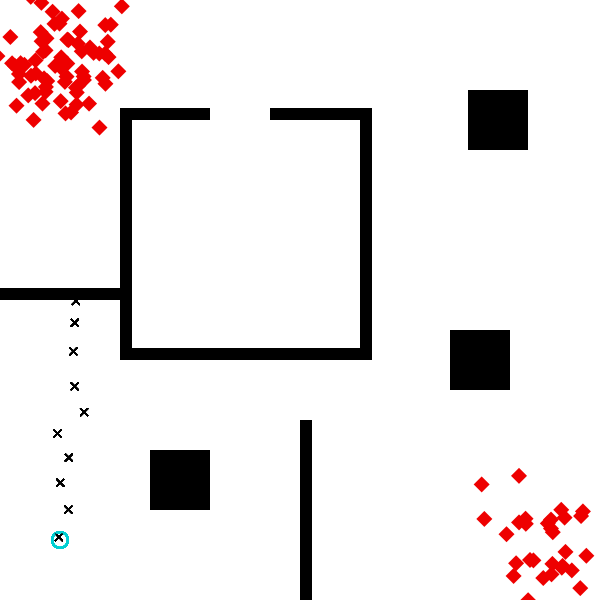

In [39]:
visualize_inference(
    measurements, scene, start, computation_amt=70, samples=100, model=chase_model)

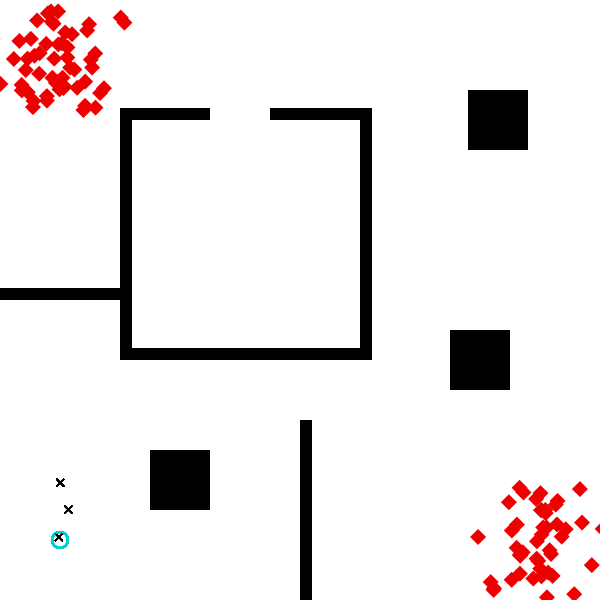

In [40]:
visualize_inference(
    measurements[1:3], scene, start, computation_amt=70, samples=100, num_ticks=3, model=chase_model)

In [41]:
chased_measurements = [
    Point(0.0980245, 0.104775),
    Point(0.148734, 0.150773),
    Point(0.170412, 0.169499),
    Point(0.204794, 0.21000),
    Point(0.2257668, 0.227711),
    Point(0.240181, 0.24304),
    Point(0.274384, 0.276242),
    Point(0.302272, 0.314463),
    Point(0.124597, 0.462056),
    Point(0.126227, 0.498338)];

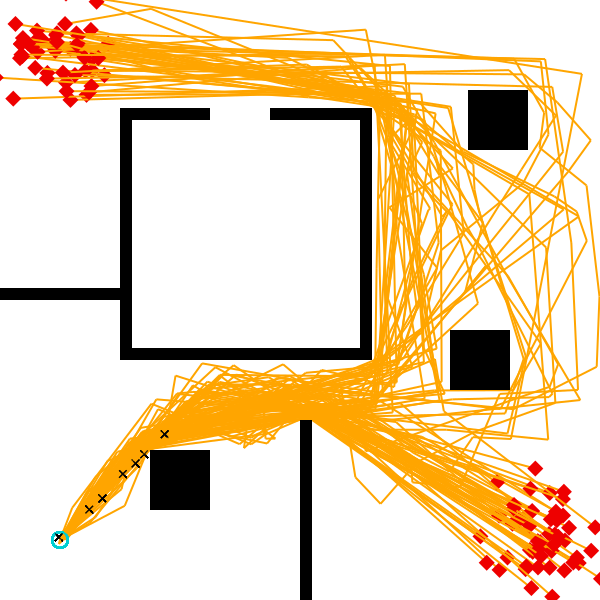

In [42]:
visualize_inference(
    chased_measurements[1:7], scene, start, computation_amt=50, samples=100, draw_path=true, num_ticks=7, model=chase_model)

In [43]:
scene = Scene(xmin=0, xmax=1, ymin=0, ymax=1)
horizontal = false
vertical = true
wall_thickness = 0.02
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.40), 0.50, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.60), 0.50, wall_thickness));
add_obstacle!(scene, make_line(vertical, Point(0.70, 0.40), 0.05, wall_thickness));
add_obstacle!(scene, make_line(vertical, Point(0.70, 0.57), 0.05, wall_thickness));

add_obstacle!(scene, make_line(vertical, Point(0.20, 0.60), 0.10, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.70), 0.10, wall_thickness));

add_obstacle!(scene, make_line(vertical, Point(0.20, 0.30), 0.10, wall_thickness));
add_obstacle!(scene, make_line(horizontal, Point(0.20, 0.30), 0.10, wall_thickness));


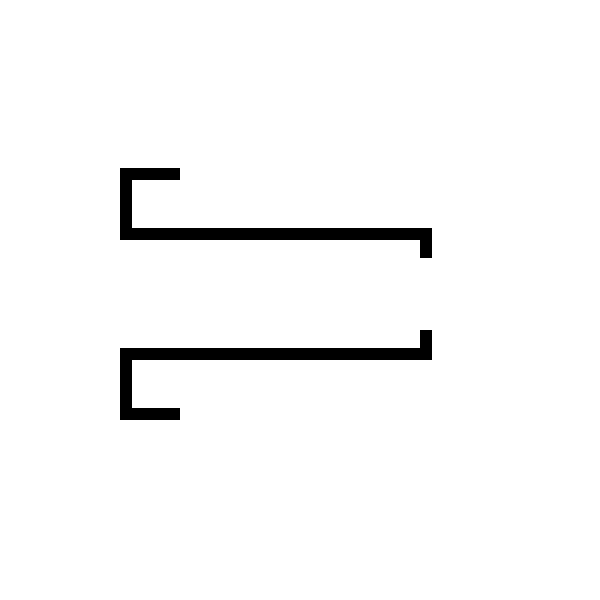

In [44]:
# We visualize the scene below.
visualize() do
    draw_scene(scene)
end

In [45]:
start = Point(0.5, 0.5)
dest = Point(0.5, 0.1)
planner_params = PlannerParams(rrt_iters=600, rrt_dt=3.0,
                               refine_iters=3500, refine_std=1.)
example_path1 = plan_path(start, dest, scene, planner_params)
example_path2 = plan_path(start, dest, scene, planner_params)
example_path3 = plan_path(start, dest, scene, planner_params)

Path(Point[Point(0.5, 0.5), Point(0.713880404994402, 0.4552851703206944), Point(0.8222352773861239, 0.38979802701171684), Point(0.5, 0.1)])

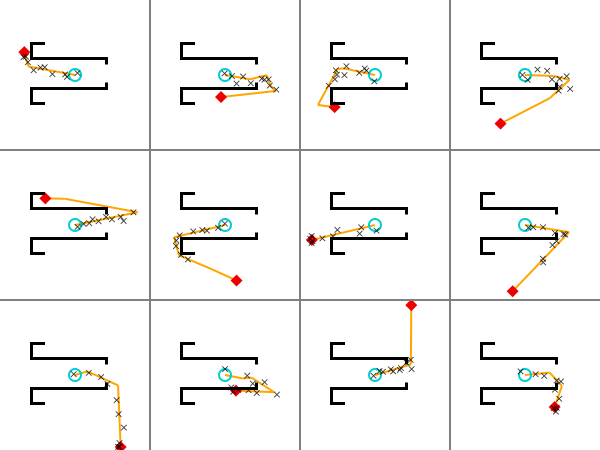

In [46]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.5
constraints[:start_y] = 0.5

traces = [Gen.generate(
    walk_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

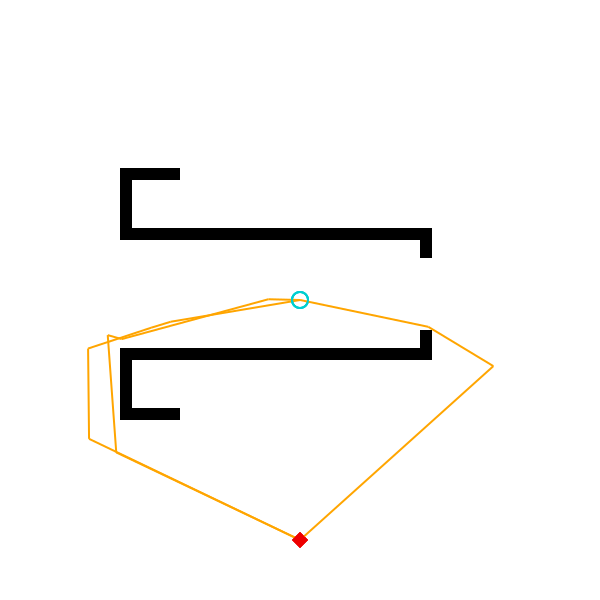

In [47]:
visualize() do
    draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path1.points);
               should_draw_measurements=false)
        draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path2.points);
               should_draw_measurements=false)
        draw_trace(Dict(:start => start,
                    :dest => dest,
                    :scene => scene,
                    :path => example_path3.points);
               should_draw_measurements=false)
end

In [48]:
@gen function restaurant_model(
        scene::Scene, dt::Float64, num_ticks::Int, 
        planner_params::PlannerParams)

    # sample the start point of the agent from the prior
    start_x ~ uniform(0, 1)
    start_y ~ uniform(0, 1)
    start = Point(start_x, start_y)

    # sample the destination point of the agent from the prior
    restaurant ~ categorical([1/3, 1/3, 1/3])
    dest_xs = [0.25, 0.25, 0.9]
    dest_ys = [0.65, 0.35, 0.9]
    dest_x ~ normal(dest_xs[restaurant], 0.0125)
    dest_y ~ normal(dest_ys[restaurant], 0.0125)
    dest = Point(dest_x, dest_y)

    # plan a path that avoids obstacles in the scene
    maybe_path = plan_path(start, dest, scene, planner_params)
    planning_failed = maybe_path === nothing
    
    # sample the speed from the prior
    speed ~ uniform(0.3, 1)

    if planning_failed   
        # path planning failed; assume agent stays at start location indefinitely
        locations = fill(start, num_ticks)
    else   
        # path planning succeeded; move along the path at constant speed
        locations = walk_path(maybe_path, speed, dt, num_ticks)
    end

    # generate noisy measurements of the agent's location at each time point
    noise = 0.02
    for (i, point) in enumerate(locations)
        x = {:meas => (i, :x)} ~ normal(point.x, noise)
        y = {:meas => (i, :y)} ~ normal(point.y, noise)
    end

    return (planning_failed, maybe_path)
end;

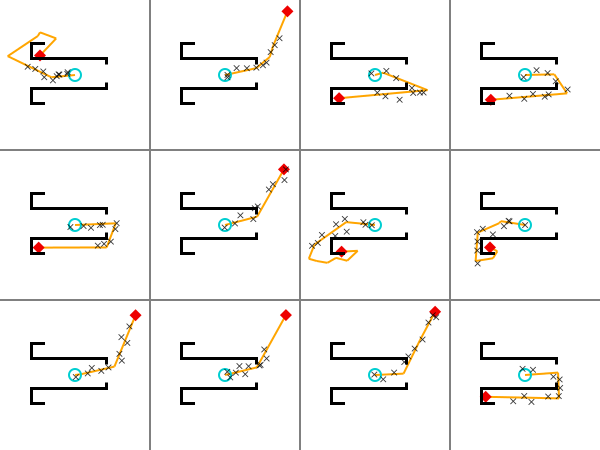

In [49]:
# Let's visualize several traces of the function, with the start location fixed to
# a point in the lower-left corner:
constraints = Gen.choicemap()
constraints[:start_x] = 0.5
constraints[:start_y] = 0.5

traces = [Gen.generate(
    restaurant_model, (scene, dt, num_ticks, planner_params), constraints
    )[1] for i in 1:12];
visualize_grid(traces, 4, 600; separators="gray") do trace, frame
    draw_trace(trace, frame; draw_measurements=true, markersize=6)
end

In [50]:
restaurant_measurements = [
    Point(0.5080245, 0.504775),
    Point(0.60734, 0.50773)];

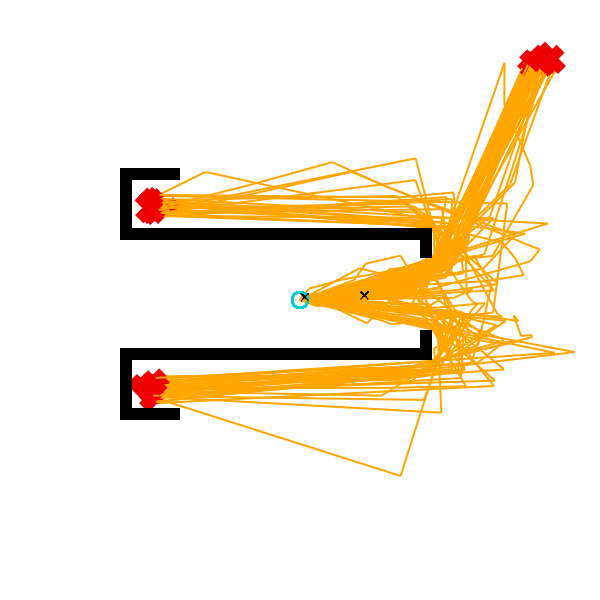

In [51]:
visualize_inference(
    restaurant_measurements, scene, start, computation_amt=50, samples=100, draw_path=true, num_ticks=2, statistics=true, restaurant_visits=restaurant_visits, model=restaurant_model)

In [52]:
restaurant_visits

3-element Vector{Float64}:
 26.0
 33.0
 41.0

In [53]:
restaurant_measurements = [
    Point(0.5080245, 0.504775),
    Point(0.40734, 0.50773)];

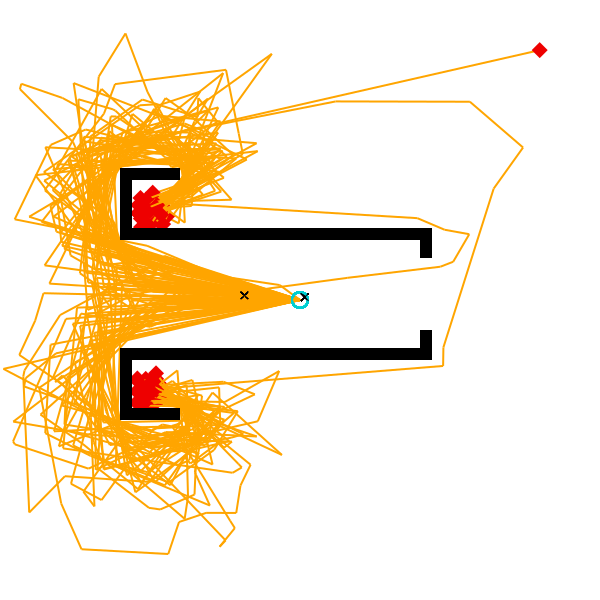

In [54]:
visualize_inference(
    restaurant_measurements, scene, start, computation_amt=50, samples=100, draw_path=true, num_ticks=2, statistics=true, restaurant_visits=restaurant_visits, model=restaurant_model)

In [55]:
restaurant_visits

3-element Vector{Float64}:
 54.0
 45.0
  1.0

## Statistical Analysis

In [56]:
@df data plot(:RestaurantChoice, seriestype=:histogram)

LoadError: UndefVarError: data not defined

In [57]:
visits = zeros(Int, 3)

for i in 1:3
    visits[i] = sum(data.RestaurantChoice .== i)
end
visits

LoadError: UndefVarError: data not defined

In [58]:
@gen function visit_model(prices)
    
    intercept ~ normal(30,30)
    
    price_slope ~ normal(0,15)

    noise ~ gamma(1,1)
    
    
    function f(price)
        return intercept + price * price_slope
    end
    
    for (i,p) in enumerate(prices)
        {(:visits, i)} ~ normal(f(p), noise)
    end
    return f
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##visit_model#285", Bool[0], false)

In [59]:
# visits = [30,40,70]

In [60]:
prices = [3., 2.5, 1.]

3-element Vector{Float64}:
 3.0
 2.5
 1.0

In [61]:
test_xs = range(0, 4, length=100)

0.0:0.04040404040404041:4.0

In [62]:
prior_traces = [visit_model([]) for _ in 1:15]

15-element Vector{var"#f#56"{Float64, Float64}}:
 (::var"#f#56"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#56"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#56"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#56"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#56"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#56"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#56"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#56"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#56"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#56"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#56"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#56"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#56"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#56"{Float64, Float64}) (generic function with 1 method)
 (::var"#f#56

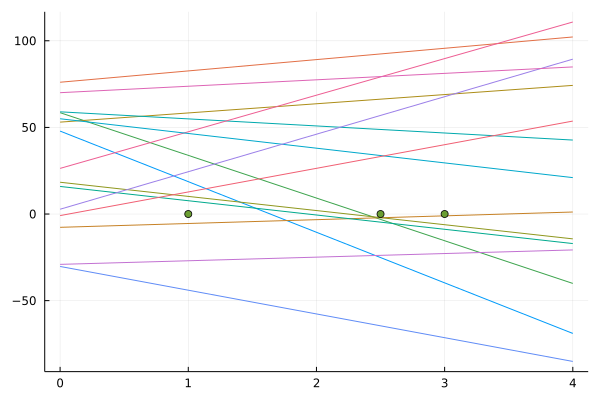

In [63]:
plot(test_xs, [prior_trace.(test_xs) for prior_trace in prior_traces], legend=false)
plot!(prices, visits, seriestype=:scatter)

In [64]:
observations = Gen.choicemap()
for (i,v) in enumerate(visits)
    observations[(:visits, i)] = v
end

traces = [importance_resampling(visit_model,
    (prices,), observations, 50,
    verbose=false)[1] for _ in 1:100]

100-element Vector{Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}}:
 Gen.DynamicDSLTrace{DynamicDSLFunction{Any}}(DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any], false, Union{Nothing, Some{Any}}[nothing], var"##visit_model#285", Bool[0], false), Trie{Any, Gen.ChoiceOrCallRecord}(Dict{Any, Gen.ChoiceOrCallRecord}(:price_slope => Gen.ChoiceOrCallRecord{Float64}(-10.366063459589821, -3.8657782268585343, NaN, true), (:visits, 2) => Gen.ChoiceOrCallRecord{Float64}(0.0, -2.4805267229145613, NaN, true), :intercept => Gen.ChoiceOrCallRecord{Float64}(23.36151640142584, -4.344618950693794, NaN, true), (:visits, 3) => Gen.ChoiceOrCallRecord{Float64}(0.0, -8.08632791287965, NaN, true), (:visits, 1) => Gen.ChoiceOrCallRecord{Float64}(0.0, -4.322016627539951, NaN, true), :noise => Gen.ChoiceOrCallRecord{Float64}(3.8054553027454134, -3.8054553027454134, NaN, true)), Dict{Any, Trie{Any, Gen.ChoiceOrCallRecord}}()), false, -26.9047237436319, 0.0, ([3.0, 2.5, 1.0],), var"#f#56

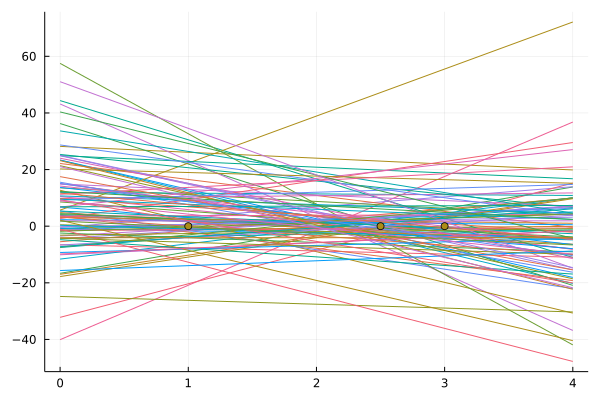

In [65]:
lines = Gen.get_retval.(traces)
plot(test_xs, [f.(test_xs) for f in lines], legend=false)
plot!(prices, visits, seriestype=:scatter)

In [66]:
choices = Gen.get_choices.(traces)
intercepts = Gen.get_value.(choices, :intercept)
price_slopes = Gen.get_value.(choices, :price_slope)
noises = Gen.get_value.(choices, :noise);

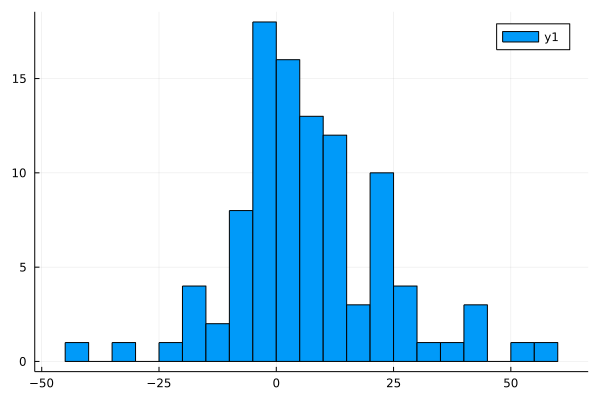

In [67]:
plot(intercepts, bins=25, seriestype=:histogram)

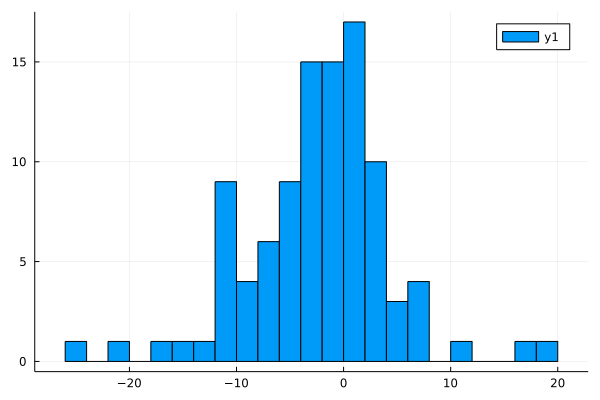

In [68]:
plot(price_slopes, bins=25, seriestype=:histogram)

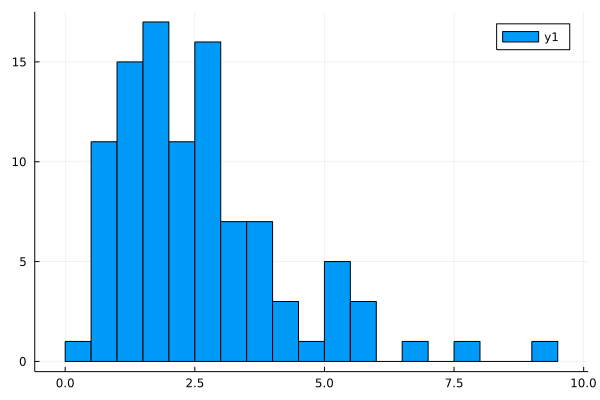

In [69]:
plot(noises, bins=25, seriestype=:histogram)

In [70]:
@gen function visit_full_model(prices, qualities, staff)
    
    intercept ~ normal(30,30)
    
    price_slope ~ normal(0,15)
    quality_slope ~ normal(0,15)
    staff_slope ~ normal(0,15)
    
    noise ~ gamma(1,1)
    
    
    function f(price, quality, staff)
        return intercept + price * price_slope + quality * quality_slope + staff * staff_slope
    end
    
    for (i,p) in enumerate(prices)
        q = qualities[i]
        s = staff[i]
        {(:visits, i)} ~ normal(f(p,q,s), noise)
    end
    return f
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], var"##visit_full_model#293", Bool[0, 0, 0], false)

In [71]:
qualities = [0.7, 0.5, 0.7]

3-element Vector{Float64}:
 0.7
 0.5
 0.7

In [72]:
staff = [0.5, 0.2, 1.]

3-element Vector{Float64}:
 0.5
 0.2
 1.0

In [73]:
traces = [importance_resampling(visit_full_model,
    (prices, qualities, staff), observations, 50,
    verbose=false)[1] for _ in 1:100]
lines = Gen.get_retval.(traces)

100-element Vector{var"#f#65"{Float64, Float64, Float64, Float64}}:
 (::var"#f#65"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#65"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#65"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#65"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#65"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#65"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#65"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#65"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#65"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#65"{Float64, Float64, Float64, Float64}) (generic function with 1 method)
 (::var"#f#65"{Float64, Float64, Float64, Float64}) (generic function with 1 metho

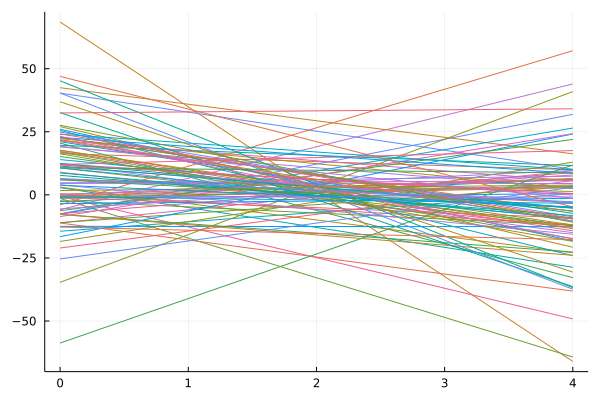

In [74]:
test_xs = range(0, 4, length=100)
plot(test_xs, [f.(test_xs, [0.5 for _ in 1:100], [0.5 for _ in 1:100]) for f in lines], legend=false)

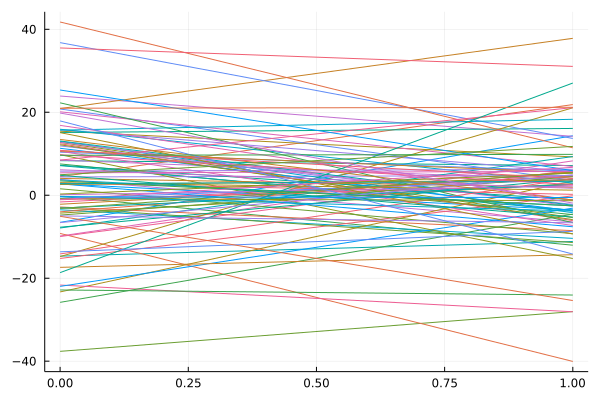

In [75]:
test_xs = range(0,1,length=20)
plot(test_xs, [f.([2 for _ in 1:20], test_xs, [0.5 for _ in 1:20]) for f in lines], legend=false)

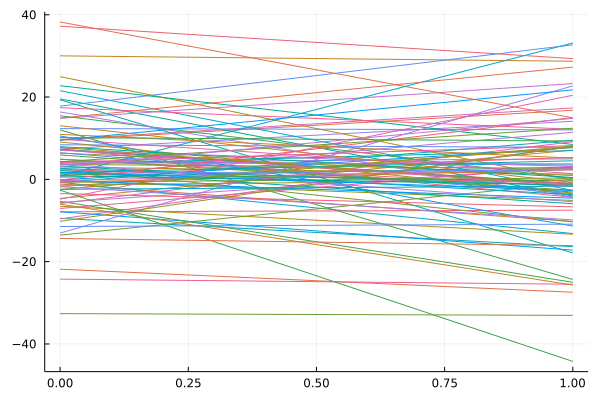

In [76]:
test_xs = range(0,1,length=20)
plot(test_xs, [f.([2 for _ in 1:20], [0.5 for _ in 1:20], test_xs) for f in lines], legend=false)

In [77]:
choices = Gen.get_choices.(traces)
intercepts = Gen.get_value.(choices, :intercept)
price_slopes = Gen.get_value.(choices, :price_slope)
quality_slopes = Gen.get_value.(choices, :quality_slope)
staff_slopes = Gen.get_value.(choices, :staff_slope)
noises = Gen.get_value.(choices, :noise);

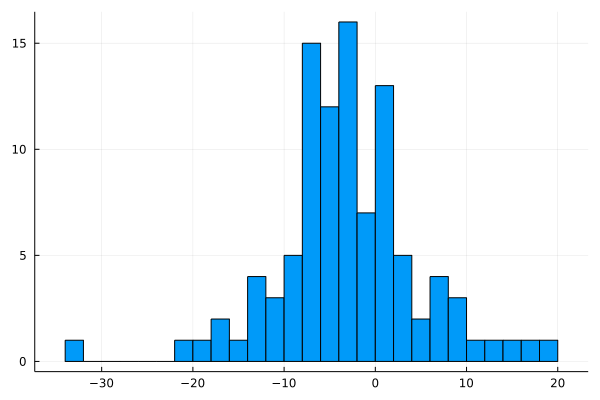

In [78]:
plot(price_slopes, bins=25, seriestype=:histogram, legend=false)

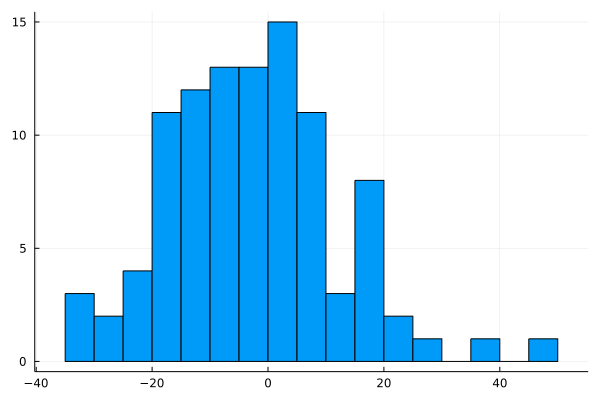

In [79]:
plot(quality_slopes, bins=35, seriestype=:histogram, legend=false)

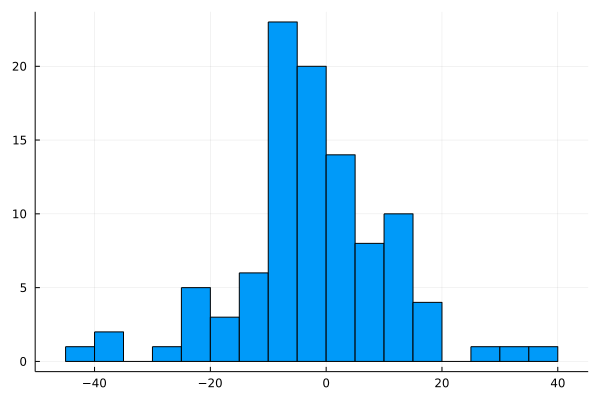

In [80]:
plot(staff_slopes, bins=35, seriestype=:histogram, legend=false)

## Predictive Distribution
https://www.mhnederlof.nl/bayesnormalupdate.html

In [81]:
sample_intercept_mu, sample_intercept_std = mean_and_std(intercepts) 

(10.824605974230282, 17.994015195117846)

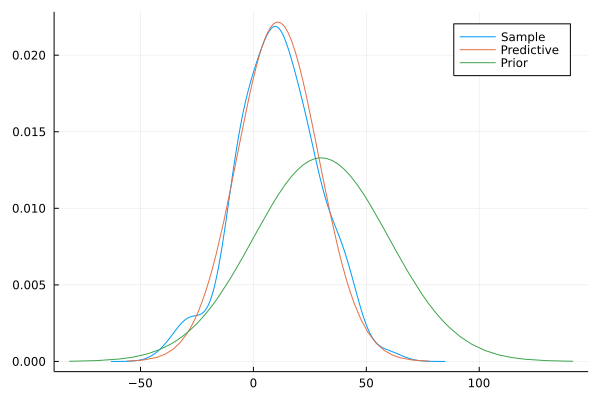

In [82]:
plot(intercepts, seriestype=:density, label="Sample")
plot!(Normal(sample_intercept_mu, sample_intercept_std), label="Predictive")
plot!(Normal(30, 30), label="Prior")

In [83]:
sample_price_slope_mu, sample_price_slope_std = mean_and_std(price_slopes) 

(-3.067337112003067, 7.8943375504977045)

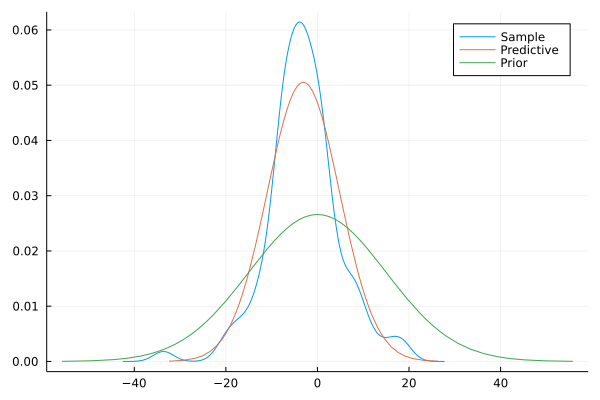

In [84]:
plot(price_slopes, seriestype=:density, label="Sample")
plot!(Normal(sample_price_slope_mu, sample_price_slope_std), label="Predictive")
plot!(Normal(0, 15), label="Prior")

In [85]:
sample_quality_slope_mu, sample_quality_slope_std = mean_and_std(quality_slopes)

(-2.558320032484569, 14.21688606573119)

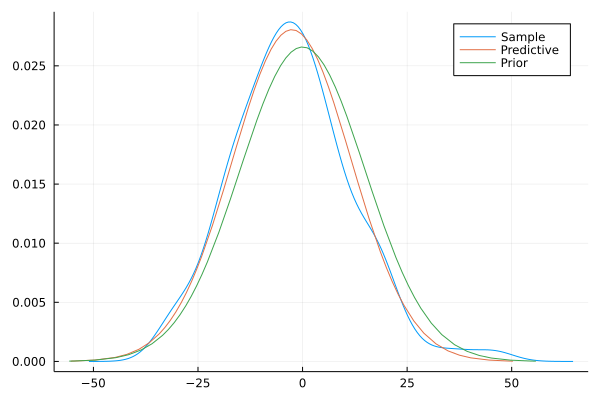

In [86]:
plot(quality_slopes, seriestype=:density, label="Sample")
plot!(Normal(sample_quality_slope_mu, sample_quality_slope_std), label="Predictive")
plot!(Normal(0, 15), label="Prior")

In [87]:
sample_staff_slope_mu, sample_staff_slope_std = mean_and_std(staff_slopes)

(-2.367846387749458, 13.006585492118049)

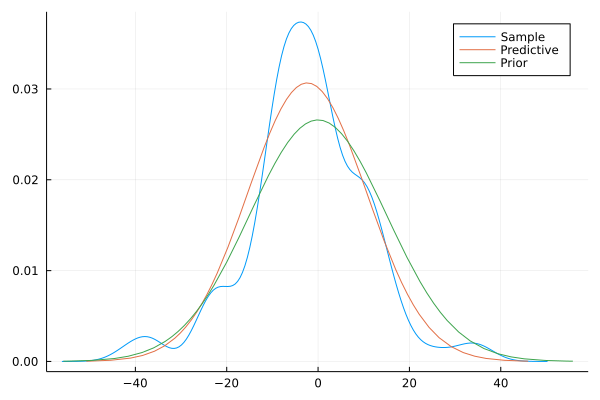

In [88]:
plot(staff_slopes, seriestype=:density, label="Sample")
plot!(Normal(sample_staff_slope_mu, sample_staff_slope_std), label="Predictive")
plot!(Normal(0, 15), label="Prior")

In [89]:
sample_noises_mu, sample_noises_std = mean_and_std(noises)

(2.683547813175119, 1.4294954655124692)

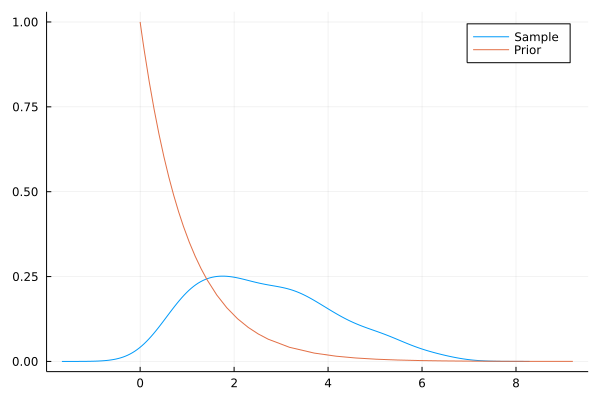

In [90]:
plot(noises, seriestype=:density, label="Sample")
# plot!(Normal(sample_noises_mu, sample_noises_std), label="Predictive")
plot!(Gamma(1, 1), label="Prior")